<a href="https://colab.research.google.com/github/Aliyahk888/GAN-based-Image-Restoration-and-Colourization/blob/main/Combined_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
!unzip /content/drive/MyDrive/Image_data/dataset.zip

Archive:  /content/drive/MyDrive/Image_data/dataset.zip
replace data/24322.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/24322.jpg          
  inflating: data/24315.jpg          
  inflating: data/24321.jpg          
  inflating: data/24269.jpg          
  inflating: data/24301.jpg          
  inflating: data/24294.jpg          
  inflating: data/24304.jpg          
  inflating: data/24334.jpg          
  inflating: data/24329.jpg          
  inflating: data/24300.jpg          
  inflating: data/24325.jpg          
  inflating: data/24324.jpg          
  inflating: data/24319.jpg          
  inflating: data/24317.jpg          
  inflating: data/24328.jpg          
  inflating: data/24309.jpg          
  inflating: data/24297.jpg          
  inflating: data/24290.jpg          
  inflating: data/24332.jpg          
  inflating: data/24310.jpg          
  inflating: data/24323.jpg          
  inflating: data/24279.jpg          
  inflating: data/24282.jpg          
  infl

In [1]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
import os
from tensorflow import keras
import argparse
import cv2

# The batch size we'll use for training
batch_size = 64

# Size of the image required to train our model
img_size = 128

# These many images will be used from the data archive
dataset_split = 2500

master_dir = 'data'
x = []
y = []
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( img_size , img_size ) )
    # Normalize the RGB image array
    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    gray_image = rgb_image.convert( 'L' )

    # Normalize the grayscale image array
    gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size ) ) ) / 255
    #gray_img_array = cv2.blur(gray_img_array,(6,6)) - to blur
    #gray_blur=cv2.blur(gray_img_array,(6,6))
    # Append both the image arrays
    x.append( gray_img_array )
    y.append( rgb_img_array )



In [2]:
# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split( np.array(x) , np.array(y) , test_size=0.1 )

# Construct tf.data.Dataset object

train_x = np.repeat(train_x[..., np.newaxis], 3, -1)
print(train_x.shape)
test_x = np.repeat(test_x[..., np.newaxis], 3, -1)

dataset = tf.data.Dataset.from_tensor_slices( (train_x , train_y ) )
dataset = dataset.batch( batch_size )

(2250, 128, 128, 3)


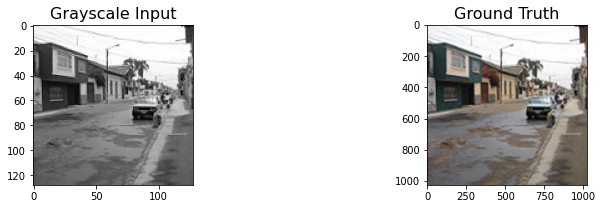

In [3]:
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow(test_x[0] , cmap='gray' )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[0] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

In [4]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x



In [8]:
def get_generator_model():
    """ Input """
    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 3 ) )

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    #print(resnet50.summary())

    """ Encoder """
    s1 = resnet50.get_layer("input_4").output           ## (128 x 128)
    s2 = resnet50.get_layer("conv1_relu").output        ## (64 x 64)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (32 x 32)
    s4 = resnet50.get_layer("conv3_block4_out").output
    s5 = resnet50.get_layer("conv4_block6_out").output
    b1 = resnet50.get_layer("conv5_block3_out").output ## (4 x 4)

    """ Bridge """
    #b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s5, 128)                    
    d2 = decoder_block(d1, s4, 64)                    
    d3 = decoder_block(d2, s3, 32)                    
    d4 = decoder_block(d3, s2, 16)
    d5 = decoder_block(d4, s1, 8)                      

    """ Output """
    outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(d5)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

In [9]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 128 , 128 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    return model


In [10]:
from keras.applications.vgg16 import VGG16
import keras.backend as K
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
img_shape=(128,128,3)
K_1=145
K_2=170
vgg = VGG16(include_top=False, weights='imagenet', input_shape=img_shape)
lossModel = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

###ADDED

def lossL1(yTrue, yPred):
    y=tf.cast(yTrue, tf.float32)
    return K.mean(K.abs(yPred - yTrue))

def lossPerceptual(yTrue, yPred):
    lossModel.trainable = False
    return K.mean(K.square(lossModel(yTrue) - lossModel(yPred)))

def generator_loss(fake_output , real_y):
    # gan_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    # real_y = tf.cast( real_y , 'float32' )
    # mae_loss=mae( fake_output , real_y )
    # total_loss = gan_loss + (100*mae_loss)
    #return total_loss
    return K_1 * lossPerceptual(real_y, fake_output)+K_2 * lossL1(float(real_y), float(fake_output))




generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_generator_model()
discriminator = get_discriminator_model()


In [11]:
@tf.function
def train_step( input_x , real_y ):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        print(generated_images[0].shape)

        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)

        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)

        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )

        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )

    
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
num_epochs = 200

for e in range( num_epochs ):
    print( e )
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        print( x.shape )
        train_step( x , y )
        


0
(64, 128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(10, 128, 128, 3)
(128, 128, 3)
1
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)
(64, 128, 128, 3)


In [ ]:
y = generator( test_x[0 : ] ).numpy()
generator.save("/content/drive/MyDrive/Image_data_Resnet_200_withperception")

In [ ]:
for i in range(len(test_x)):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( test_x[i] , cmap='gray' )

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

  plt.show()

In [147]:

# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model

generator = load_model("/content/drive/MyDrive/Image_data_Resnet_50_withperception")

In [165]:
def custom():
  batch_size = 64

  # Size of the image required to train our model
  img_size = 128

  # These many images will be used from the data archive
  dataset_split = 2500

  master_dir = 'data'
  c = []

  custom_image = Image.open('/content/mountain.jpeg').resize( ( img_size , img_size ) )
  # Normalize the RGB image array
  custom_image = custom_image.convert( 'L' )

  # Normalize the grayscale image array
  custom_img_array = ( np.asarray( custom_image ).reshape( ( img_size , img_size ) ) ) / 255

  #custom_img_array=cv2.blur(custom_img_array,(6,6))
  # Append both the image arrays
  c.append( custom_img_array )
  #y.append( rgb_img_array )
# Train-test splitting
  custom_x = np.array(c)

  # Construct tf.data.Dataset object

  cust_x = np.repeat(custom_x[..., np.newaxis], 3, -1)
  pred = generator(cust_x[0 : ] ).numpy()


  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow(custom_x[0] , cmap='gray' )

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray( ( pred[0] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )


  plt.show()



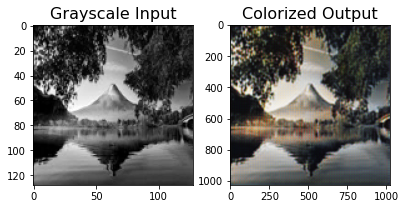

In [166]:
custom()

In [ ]:
$